FISTA converged at iteration 498
FISTA converged at iteration 622
FISTA converged at iteration 795
FISTA converged at iteration 876
FISTA converged at iteration 1051
FISTA converged at iteration 1107
FISTA converged at iteration 1222
FISTA converged at iteration 1383
FISTA converged at iteration 1799
FISTA converged at iteration 1943
FISTA converged at iteration 2537
FISTA converged at iteration 2373
FISTA converged at iteration 2617
FISTA converged at iteration 2453
FISTA converged at iteration 2116
FISTA converged at iteration 2308
FISTA converged at iteration 2135
FISTA converged at iteration 2091
FISTA converged at iteration 2813
FISTA converged at iteration 2048
FISTA converged at iteration 2824
FISTA converged at iteration 2635
FISTA converged at iteration 3391
FISTA converged at iteration 3828
FISTA converged at iteration 3695
FISTA converged at iteration 3053
FISTA converged at iteration 3642
FISTA converged at iteration 3245
FISTA converged at iteration 2903
FISTA converged at

,Method,n_informative,noise,time,n_selected,correct_count,false_positives,fraction_recovered
0,lasso_cd,20,0,19.484490,60,20,40,1.000
1,lasso_fista,20,0,0.073732,47,20,27,1.000
2,lasso_ista,20,0,0.067319,283,16,267,0.800
3,square_root_lasso,20,0,12.415761,20,20,0,1.000
4,lasso_cd,20,3,19.374353,102,18,84,0.900
5,lasso_fista,20,3,0.074673,96,18,78,0.900
6,lasso_ista,20,3,0.068153,282,16,266,0.800
7,square_root_lasso,20,3,5.825360,60,18,42,0.900
8,lasso_cd,20,30,19.492262,103,16,87,0.800
9,lasso_fista,20,30,0.074000,99,16,83,0.800


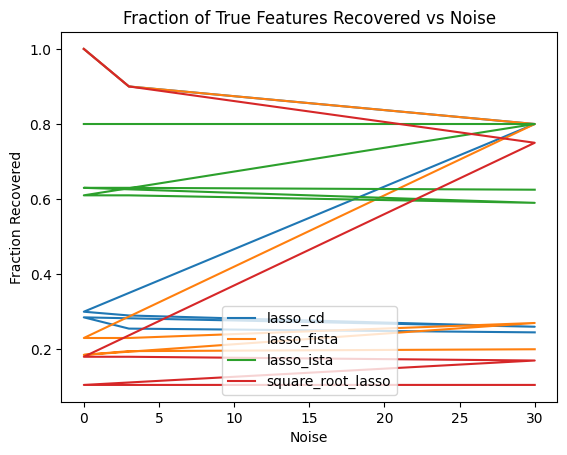

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.datasets import make_regression

# Import your Lasso methods (coordinate descent, ISTA, FISTA, etc.)
from methods.lasso_cd import lasso_coordinate_descent
from methods.lasso_fista import lasso_fista
from methods.lasso_ista import lasso_ista
from methods.square_root_lasso import square_root_lasso

######################################
# 1. CONFIGURATION
######################################
n_samples = 100
p = 1000
noise_levels = [0, 3, 30]
n_informative_list = [20, 100, 200]

# We'll store the results in a list of dicts, then build a DataFrame.
results = []

######################################
# 2. EXPERIMENT LOOP
######################################
for n_informative in n_informative_list:
    for noise in noise_levels:
        # Generate synthetic data using make_regression
        X_data, y_data, true_coef = make_regression(
            n_samples=n_samples,
            n_features=p,
            n_informative=n_informative,
            noise=noise,
            coef=True,
            random_state=42  # for reproducibility
        )
        
        # Identify which coefficients are nonzero in the ground truth
        true_informative_indices = np.where(true_coef != 0)[0]
        
        # Standardize X and center y
        X_mean = np.mean(X_data, axis=0)
        X_std = np.std(X_data, axis=0)
        X_scaled = (X_data - X_mean) / (X_std + 1e-8)  # avoid div by zero
        y_centered = y_data - np.mean(y_data)
        
        # Choose a lambda/tau (this can be tuned or you can do multiple)
        lam = 0.1
        tau = 0.2
        
        # Dictionary for storing each method's results
        method_results = {}
        
        #############################
        # 3. RUN LASSO_CD
        #############################
        start_time = time.time()
        beta_cd, beta_history_cd = lasso_coordinate_descent(
            X_scaled, y_centered,
            lam=lam,
            max_iter=2000,  # or some large number
            tol=1e-4
        )
        cd_time = time.time() - start_time
        
        # Evaluate the selection
        threshold = 1e-2
        selected_indices_cd = np.where(np.abs(beta_cd) > threshold)[0]
        
        # Count overlap with true informative
        common_cd = set(selected_indices_cd).intersection(set(true_informative_indices))
        fraction_recovered_cd = len(common_cd) / (len(true_informative_indices)+1e-8)
        # Possibly count false positives:
        false_pos_cd = len(selected_indices_cd) - len(common_cd)
        
        method_results["lasso_cd"] = {
            "beta": beta_cd,
            "time": cd_time,
            "n_selected": len(selected_indices_cd),
            "correct_count": len(common_cd),
            "false_positives": false_pos_cd,
            "fraction_recovered": fraction_recovered_cd
        }
        
        #############################
        # 4. RUN LASSO_FISTA
        #############################
        start_time = time.time()
        beta_fista, beta_history_fista = lasso_fista(
            X_scaled, y_centered,
            lam=lam,
            max_iter=2000,
            tol=1e-4
        )
        fista_time = time.time() - start_time
        
        selected_indices_fista = np.where(np.abs(beta_fista) > threshold)[0]
        common_fista = set(selected_indices_fista).intersection(set(true_informative_indices))
        fraction_recovered_fista = len(common_fista) / (len(true_informative_indices)+1e-8)
        false_pos_fista = len(selected_indices_fista) - len(common_fista)
        
        method_results["lasso_fista"] = {
            "beta": beta_fista,
            "time": fista_time,
            "n_selected": len(selected_indices_fista),
            "correct_count": len(common_fista),
            "false_positives": false_pos_fista,
            "fraction_recovered": fraction_recovered_fista
        }
        
        #############################
        # 5. RUN LASSO_ISTA
        #############################
        start_time = time.time()
        beta_ista, beta_history_ista = lasso_ista(
            X_scaled, y_centered,
            lam=lam,
            max_iter=2000,
            tol=1e-4
        )
        ista_time = time.time() - start_time
        
        selected_indices_ista = np.where(np.abs(beta_ista) > threshold)[0]
        common_ista = set(selected_indices_ista).intersection(set(true_informative_indices))
        fraction_recovered_ista = len(common_ista) / (len(true_informative_indices)+1e-8)
        false_pos_ista = len(selected_indices_ista) - len(common_ista)
        
        method_results["lasso_ista"] = {
            "beta": beta_ista,
            "time": ista_time,
            "n_selected": len(selected_indices_ista),
            "correct_count": len(common_ista),
            "false_positives": false_pos_ista,
            "fraction_recovered": fraction_recovered_ista
        }
        
        #############################
        # 6. RUN SQUARE-ROOT LASSO
        #############################
        start_time = time.time()
        beta_srl, sigma_srl, history_srl = square_root_lasso(
            X_scaled, y_centered,
            tau=tau,
            max_outer_iter=100,
            tol=1e-4
        )
        srl_time = time.time() - start_time
        
        selected_indices_srl = np.where(np.abs(beta_srl) > threshold)[0]
        common_srl = set(selected_indices_srl).intersection(set(true_informative_indices))
        fraction_recovered_srl = len(common_srl) / (len(true_informative_indices)+1e-8)
        false_pos_srl = len(selected_indices_srl) - len(common_srl)
        
        method_results["square_root_lasso"] = {
            "beta": beta_srl,
            "time": srl_time,
            "n_selected": len(selected_indices_srl),
            "correct_count": len(common_srl),
            "false_positives": false_pos_srl,
            "fraction_recovered": fraction_recovered_srl
        }
        
        # Append overall info to results
        for method_name, stats in method_results.items():
            results.append({
                "Method": method_name,
                "n_informative": n_informative,
                "noise": noise,
                "time": stats["time"],
                "n_selected": stats["n_selected"],
                "correct_count": stats["correct_count"],
                "false_positives": stats["false_positives"],
                "fraction_recovered": stats["fraction_recovered"]
            })

######################################
# 3. VISUALIZE / TABLE
######################################
df_results = pd.DataFrame(results)
display(df_results)

# (Optional) plotting code to see fraction_recovered vs. noise, etc.
for method in df_results["Method"].unique():
    df_m = df_results[df_results["Method"] == method]
    plt.plot(df_m["noise"], df_m["fraction_recovered"], label=method)
plt.xlabel("Noise")
plt.ylabel("Fraction Recovered")
plt.title("Fraction of True Features Recovered vs Noise")
plt.legend()
plt.show()


Converged at iteration 1236
FISTA converged at iteration 2031
FISTA converged at iteration 296
FISTA converged at iteration 301
FISTA converged at iteration 406
FISTA converged at iteration 391
FISTA converged at iteration 459
FISTA converged at iteration 516
FISTA converged at iteration 543
FISTA converged at iteration 517
FISTA converged at iteration 544
FISTA converged at iteration 549
FISTA converged at iteration 576
FISTA converged at iteration 576
FISTA converged at iteration 576
FISTA converged at iteration 576
FISTA converged at iteration 576
FISTA converged at iteration 576
FISTA converged at iteration 576
FISTA converged at iteration 603
FISTA converged at iteration 603
FISTA converged at iteration 603
FISTA converged at iteration 603
FISTA converged at iteration 603
FISTA converged at iteration 603
FISTA converged at iteration 603
FISTA converged at iteration 603
FISTA converged at iteration 603
FISTA converged at iteration 603
FISTA converged at iteration 603
FISTA converge

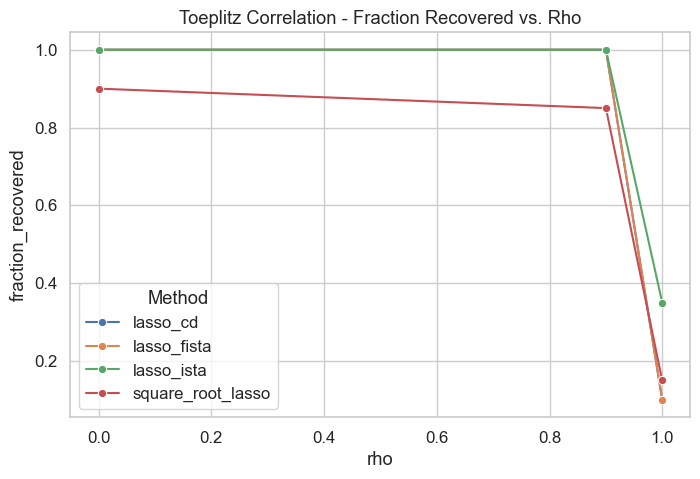

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from methods.lasso_cd import lasso_coordinate_descent
from methods.lasso_fista import lasso_fista
from methods.lasso_ista import lasso_ista
from methods.square_root_lasso import square_root_lasso

########################################
# 1. DATA GENERATION: TOEPLITZ
########################################
def generate_toeplitz_data(n, p, rho, n_informative, noise_std, random_state=None):
    """
    Generate synthetic regression data with Toeplitz correlation structure among features.
    
    X ~ N(0, Sigma), where Sigma_{ij} = rho^|i-j|.
    The true beta has n_informative nonzero coefficients (randomly placed).
    y = X beta + epsilon, with epsilon ~ N(0, noise_std^2).
    
    Returns:
      X_data   : shape (n, p)
      y_data   : shape (n,)
      true_beta: shape (p,)
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Step 1: Build covariance matrix
    Sigma = np.zeros((p, p))
    for i in range(p):
        for j in range(p):
            Sigma[i, j] = rho ** abs(i - j)
    
    # Step 2: Sample X from multivariate normal
    mean_vec = np.zeros(p)
    # We'll use a Cholesky decomposition or a symmetric sqrt for Sigma
    # to generate from N(0, Sigma).
    # For numerical stability, you might do np.linalg.cholesky(Sigma).
    cholSigma = np.linalg.cholesky(Sigma)
    
    # X_data: shape (n, p)
    # Each row is a sample from N(0, Sigma).
    standard_norm = np.random.randn(n, p)  # shape (n, p)
    X_data = standard_norm @ cholSigma
    
    # Step 3: Construct sparse true_beta
    true_beta = np.zeros(p)
    # Randomly pick n_informative indices
    informative_indices = np.random.choice(p, size=n_informative, replace=False)
    # Assign random coefficients in e.g. [5, 10] or smaller
    # Or you can let them be random normal, or a fixed magnitude.
    for idx in informative_indices:
        true_beta[idx] = np.random.uniform(5, 10) * np.random.choice([1, -1])
    
    # Step 4: Generate y
    y_data = X_data @ true_beta
    # Add Gaussian noise
    eps = np.random.randn(n) * noise_std
    y_data += eps
    
    return X_data, y_data, true_beta


########################################
# 2. EXPERIMENT FUNCTION
########################################
def run_experiment_correlated(
    n=100,
    p=500,
    rho_list=[0.0, 0.5, 0.9],
    n_informative=20,
    noise_std=1.0,
    lam=0.1,
    tau=0.2,
    random_state=42
):
    """
    For each rho in rho_list, generate Toeplitz data, run each Lasso method,
    and record results.
    """
    results = []
    
    for rho in rho_list:
        # Generate the correlated dataset
        X_data, y_data, true_beta = generate_toeplitz_data(
            n=n, p=p, rho=rho,
            n_informative=n_informative,
            noise_std=noise_std,
            random_state=random_state
        )
        
        # Find the true nonzero indices
        true_informative_indices = np.where(true_beta != 0)[0]
        
        # Standardize X and center y
        X_mean = np.mean(X_data, axis=0)
        X_std = np.std(X_data, axis=0) + 1e-8
        X_scaled = (X_data - X_mean) / X_std
        y_centered = y_data - np.mean(y_data)
        
        # We'll run the 4 Lasso methods
        lasso_methods = {
            "lasso_cd": lambda X, y: lasso_coordinate_descent(X, y, lam=lam),
            "lasso_fista": lambda X, y: lasso_fista(X, y, lam=lam),
            "lasso_ista": lambda X, y: lasso_ista(X, y, lam=lam),
            "square_root_lasso": lambda X, y: square_root_lasso(X, y, tau=tau)
        }
        
        for method_name, func in lasso_methods.items():
            # Run the method
            start_time = time.time()
            
            if method_name == "square_root_lasso":
                beta_est, sigma_est, history = func(X_scaled, y_centered)
            else:
                beta_est, history = func(X_scaled, y_centered)
            
            elapsed = time.time() - start_time
            
            # Evaluate selection
            threshold = 1e-1
            selected_indices = np.where(np.abs(beta_est) > threshold)[0]
            common = set(selected_indices).intersection(set(true_informative_indices))
            
            fraction_recovered = len(common) / (len(true_informative_indices) + 1e-8)
            false_positives = len(selected_indices) - len(common)
            
            # Save results
            results.append({
                "Method": method_name,
                "rho": rho,
                "n": n,
                "p": p,
                "noise_std": noise_std,
                "n_informative": n_informative,
                "time": elapsed,
                "n_selected": len(selected_indices),
                "correct_count": len(common),
                "false_positives": false_positives,
                "fraction_recovered": fraction_recovered
            })
    return pd.DataFrame(results)


########################################
# 3. RUN THE EXPERIMENT
########################################
if __name__ == "__main__":
    df_corr = run_experiment_correlated(
        n=100,
        p=500,
        rho_list=[0.0, 0.9, 0.9999],
        n_informative=20,
        noise_std=3.0,
        lam=0.1,
        tau=0.2,
        random_state=42
    )
    
    print(df_corr)
    
    # (Optional) Plot results
    # Example: fraction recovered vs rho, grouped by method
    import seaborn as sns
    sns.set(style="whitegrid", font_scale=1.1)
    
    plt.figure(figsize=(8,5))
    sns.lineplot(
        data=df_corr,
        x="rho",
        y="fraction_recovered",
        hue="Method",
        marker="o"
    )
    plt.title("Toeplitz Correlation - Fraction Recovered vs. Rho")
    plt.show()


df_corr

In [7]:
df_corr

,Method,rho,n,p,noise_std,n_informative,time,n_selected,correct_count,false_positives,fraction_recovered
0,lasso_cd,0.0000,100,500,3.0,20,4.597345,86,20,66,1.00
1,lasso_fista,0.0000,100,500,3.0,20,0.058178,86,20,66,1.00
2,lasso_ista,0.0000,100,500,3.0,20,0.130839,87,20,67,1.00
3,square_root_lasso,0.0000,100,500,3.0,20,0.485386,34,18,16,0.90
4,lasso_cd,0.9000,100,500,3.0,20,4.448004,68,20,48,1.00
5,lasso_fista,0.9000,100,500,3.0,20,0.116499,69,20,49,1.00
6,lasso_ista,0.9000,100,500,3.0,20,0.128784,86,20,66,1.00
7,square_root_lasso,0.9000,100,500,3.0,20,4.514939,38,17,21,0.85
8,lasso_cd,0.9999,100,500,3.0,20,10.273252,21,2,19,0.10
9,lasso_fista,0.9999,100,500,3.0,20,0.142512,21,2,19,0.10


In [9]:
def generate_low_rank_data(n, p, rank, n_informative, noise_std, random_state=None):
    """
    Generate a nearly low-rank design matrix X of shape (n, p).
    Then create a sparse beta, and y = X beta + noise.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Step 1: random X_0 ~ Normal(0,1)
    X_0 = np.random.randn(n, p)
    
    # Step 2: SVD
    U, S, Vt = np.linalg.svd(X_0, full_matrices=False)  # shapes: (n,r), (r,), (r,p) with r=min(n,p)
    
    # Step 3: Force small singular values. For example, keep only 'rank' large values.
    # We'll keep the first 'rank' singular values as is, and make the rest near zero.
    # If rank > min(n,p), we obviously can't do that, so you might do rank <= min(n,p).
    
    for i in range(len(S)):
        if i >= rank:
            S[i] = 1e-3 * S[i]  # or zero them out if you want
        # or create a slow decay to approach ill-conditioning
    
    # Rebuild X
    X_data = (U * S) @ Vt
    
    # Step 4: create a sparse beta
    true_beta = np.zeros(p)
    idx_inform = np.random.choice(p, size=n_informative, replace=False)
    for idx in idx_inform:
        true_beta[idx] = np.random.uniform(5, 10) * np.random.choice([1,-1])
    
    # Step 5: generate y
    y_data = X_data @ true_beta
    eps = noise_std * np.random.randn(n)
    y_data += eps
    
    return X_data, y_data, true_beta


def run_experiment_low_rank(rank_list=[5, 50, 90], n=100, p=100, n_informative=10, noise_std=1.0, lam=0.1, tau=0.2):
    results = []
    for rank_val in rank_list:
        X_data, y_data, true_beta = generate_low_rank_data(
            n=n, p=p, rank=rank_val,
            n_informative=n_informative,
            noise_std=noise_std,
            random_state=42
        )
        
        # Standardize, run methods, same as above...
        # ... store fraction_recovered, false_positives, time, etc.
        
        # Summarize in a DataFrame as well, returning results
    
    return pd.DataFrame(results)


Converged at iteration 850
FISTA converged at iteration 1852
FISTA converged at iteration 186
FISTA converged at iteration 186
FISTA converged at iteration 210
FISTA converged at iteration 235
FISTA converged at iteration 279
FISTA converged at iteration 282
FISTA converged at iteration 283
FISTA converged at iteration 284
FISTA converged at iteration 286
FISTA converged at iteration 287
FISTA converged at iteration 289
FISTA converged at iteration 304
FISTA converged at iteration 348
FISTA converged at iteration 338
FISTA converged at iteration 316
FISTA converged at iteration 321
FISTA converged at iteration 376
FISTA converged at iteration 368
FISTA converged at iteration 414
FISTA converged at iteration 417
FISTA converged at iteration 441
FISTA converged at iteration 444
FISTA converged at iteration 433
FISTA converged at iteration 435
FISTA converged at iteration 436
FISTA converged at iteration 437
FISTA converged at iteration 438
FISTA converged at iteration 439
FISTA converged

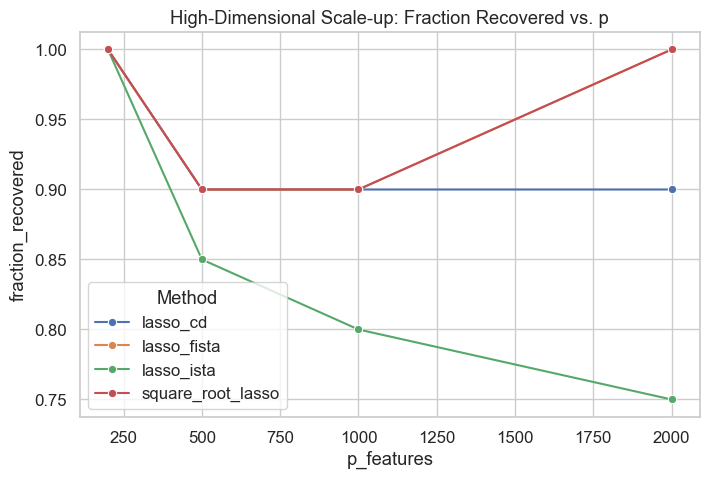

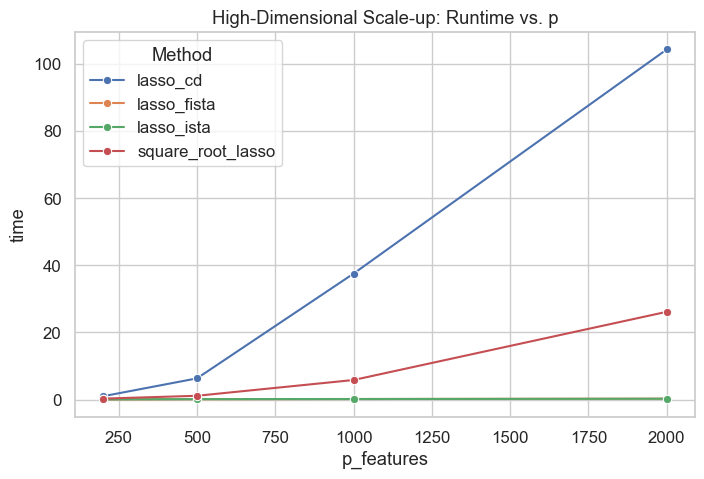

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.datasets import make_regression

# Import your Lasso methods
from methods.lasso_cd import lasso_coordinate_descent
from methods.lasso_fista import lasso_fista
from methods.lasso_ista import lasso_ista
from methods.square_root_lasso import square_root_lasso

def experiment_vary_p(
    n=100,
    p_list=[200, 500, 1000, 2000],
    n_informative=20,
    noise=3.0,
    lam=0.1,
    tau=0.2,
    random_state=42
):
    """
    Runs an experiment where we fix n, vary p, and check how Lasso methods scale up.
    Returns a DataFrame summarizing the results.
    """
    results = []
    for p in p_list:
        # 1. Generate data
        X_data, y_data, true_coef = make_regression(
            n_samples=n,
            n_features=p,
            n_informative=n_informative,
            noise=noise,
            coef=True,
            random_state=random_state
        )
        
        # Identify the true nonzero indices
        true_informative_indices = np.where(true_coef != 0)[0]
        
        # 2. Standardize and center
        X_mean = np.mean(X_data, axis=0)
        X_std = np.std(X_data, axis=0) + 1e-8
        X_scaled = (X_data - X_mean) / X_std
        y_centered = y_data - np.mean(y_data)
        
        # 3. Run each Lasso method
        lasso_methods = {
            "lasso_cd": lambda X, y: lasso_coordinate_descent(X, y, lam=lam),
            "lasso_fista": lambda X, y: lasso_fista(X, y, lam=lam),
            "lasso_ista": lambda X, y: lasso_ista(X, y, lam=lam),
            "square_root_lasso": lambda X, y: square_root_lasso(X, y, tau=tau)
        }
        
        for method_name, func in lasso_methods.items():
            start_time = time.time()
            if method_name == "square_root_lasso":
                beta_est, sigma_est, history_srl = func(X_scaled, y_centered)
            else:
                beta_est, beta_history = func(X_scaled, y_centered)
            elapsed = time.time() - start_time
            
            # 4. Evaluate selection
            threshold = 1e-2
            selected_indices = np.where(np.abs(beta_est) > threshold)[0]
            common = set(selected_indices).intersection(set(true_informative_indices))
            
            fraction_recovered = len(common) / (len(true_informative_indices) + 1e-8)
            false_positives = len(selected_indices) - len(common)
            
            # Optionally measure coefficient error as well
            # l2_error = np.linalg.norm(beta_est - true_coef, ord=2)
            
            results.append({
                "Method": method_name,
                "n_samples": n,
                "p_features": p,
                "n_informative": n_informative,
                "noise": noise,
                "time": elapsed,
                "n_selected": len(selected_indices),
                "correct_count": len(common),
                "false_positives": false_positives,
                "fraction_recovered": fraction_recovered
                # "l2_error": l2_error
            })
    return pd.DataFrame(results)

# Example usage:
if __name__ == "__main__":
    p_list = [200, 500, 1000, 2000]
    df_scaleup = experiment_vary_p(
        n=100,
        p_list=p_list,
        n_informative=20,
        noise=3.0,
        lam=0.1,
        tau=0.2,
        random_state=42
    )
    
    print(df_scaleup)
    
    # Quick plot: fraction recovered vs. p, color-coded by method
    import seaborn as sns
    sns.set(style="whitegrid", font_scale=1.1)
    
    plt.figure(figsize=(8,5))
    sns.lineplot(
        data=df_scaleup,
        x="p_features",
        y="fraction_recovered",
        hue="Method",
        marker="o"
    )
    plt.title("High-Dimensional Scale-up: Fraction Recovered vs. p")
    plt.show()
    
    # Another plot: runtime vs. p
    plt.figure(figsize=(8,5))
    sns.lineplot(
        data=df_scaleup,
        x="p_features",
        y="time",
        hue="Method",
        marker="o"
    )
    plt.title("High-Dimensional Scale-up: Runtime vs. p")
    plt.show()


In [11]:
df_scaleup

,Method,n_samples,p_features,n_informative,noise,time,n_selected,correct_count,false_positives,fraction_recovered
0,lasso_cd,100,200,20,3.0,0.996005,85,20,65,1.00
1,lasso_fista,100,200,20,3.0,0.027653,85,20,65,1.00
2,lasso_ista,100,200,20,3.0,0.062541,86,20,66,1.00
3,square_root_lasso,100,200,20,3.0,0.282119,29,20,9,1.00
4,lasso_cd,100,500,20,3.0,6.318442,89,18,71,0.90
5,lasso_fista,100,500,20,3.0,0.104394,89,18,71,0.90
6,lasso_ista,100,500,20,3.0,0.139198,128,17,111,0.85
7,square_root_lasso,100,500,20,3.0,1.129610,41,18,23,0.90
8,lasso_cd,100,1000,20,3.0,37.525781,96,18,78,0.90
9,lasso_fista,100,1000,20,3.0,0.169552,95,18,77,0.90


In [1]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import KFold
from methods.lasso_cd import lasso_coordinate_descent

def cross_validate_lasso_cd(X, y, lam_grid, n_splits=5, max_iter=2000, tol=1e-4, random_state=42):
    """
    K-fold cross-validation to select the best lam from lam_grid for Lasso with coordinate descent.
    
    Args:
        X (np.ndarray): shape (n, p), design matrix.
        y (np.ndarray): shape (n,), target vector.
        lam_grid (list or np.ndarray): list of lambda values to try.
        n_splits (int): number of CV folds.
        max_iter (int): max iterations for the Lasso solver.
        tol (float): tolerance for convergence.
        random_state (int): random seed for fold splitting.
        
    Returns:
        best_lam (float): the lambda value with the lowest average CV error.
        cv_results (pd.DataFrame): DataFrame with columns ["lam", "cv_error_mean", "cv_error_std"].
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    n = X.shape[0]
    
    cv_records = []
    
    for lam in lam_grid:
        fold_errors = []
        
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            # Fit Lasso on the training fold
            beta_est, _ = lasso_coordinate_descent(
                X_train, y_train,
                lam=lam,
                max_iter=max_iter,
                tol=tol
            )
            
            # Predict on the validation fold
            y_pred = X_val @ beta_est
            mse_fold = np.mean((y_val - y_pred)**2)
            fold_errors.append(mse_fold)
        
        mean_error = np.mean(fold_errors)
        std_error = np.std(fold_errors)
        cv_records.append((lam, mean_error, std_error))
    
    cv_df = pd.DataFrame(cv_records, columns=["lam", "cv_error_mean", "cv_error_std"])
    # pick lam with minimum mean error
    best_row = cv_df.loc[cv_df["cv_error_mean"].idxmin()]
    best_lam = best_row["lam"]
    
    return best_lam, cv_df


# Example usage:
if __name__ == "__main__":
    from sklearn.datasets import make_regression
    
    # Generate some data
    X_data, y_data, true_coef = make_regression(
        n_samples=100, n_features=50, n_informative=10,
        noise=5.0, random_state=42, coef=True
    )
    
    # Standardize
    X_mean = np.mean(X_data, axis=0)
    X_std = np.std(X_data, axis=0) + 1e-8
    X_scaled = (X_data - X_mean) / X_std
    y_centered = y_data - np.mean(y_data)
    
    # Build a lam_grid in log-scale
    # (in practice, you might auto-estimate lam_max or do a wider range)
    lam_grid = np.logspace(-2, 1, 10)  # from 0.01 to 10
    
    # Cross-validate
    best_lam, cv_df = cross_validate_lasso_cd(
        X_scaled, y_centered,
        lam_grid=lam_grid,
        n_splits=5,
        max_iter=2000,
        tol=1e-4,
        random_state=42
    )
    
    print("CV results:")
    print(cv_df)
    print(f"\nBest lam from CV: {best_lam:.4f}")
    
    # Optionally refit final model with best lam
    beta_final, _ = lasso_coordinate_descent(
        X_scaled, y_centered,
        lam=best_lam,
        max_iter=2000,
        tol=1e-4
    )
    print("\nFinal model coefficients (first 10):", beta_final[:10])


Converged at iteration 74
Converged at iteration 84
Converged at iteration 60
Converged at iteration 74
Converged at iteration 56
Converged at iteration 63
Converged at iteration 63
Converged at iteration 59
Converged at iteration 59
Converged at iteration 53
Converged at iteration 59
Converged at iteration 52
Converged at iteration 56
Converged at iteration 59
Converged at iteration 49
Converged at iteration 48
Converged at iteration 47
Converged at iteration 45
Converged at iteration 47
Converged at iteration 38
Converged at iteration 35
Converged at iteration 35
Converged at iteration 39
Converged at iteration 36
Converged at iteration 27
Converged at iteration 21
Converged at iteration 23
Converged at iteration 24
Converged at iteration 26
Converged at iteration 22
Converged at iteration 17
Converged at iteration 16
Converged at iteration 19
Converged at iteration 18
Converged at iteration 16
Converged at iteration 12
Converged at iteration 14
Converged at iteration 13
Converged at

In [ ]:
import numpy as np
from methods.lasso_cd import lasso_coordinate_descent

def debiased_lasso_single_coord(X, y, lam, coord=0, max_iter=2000, tol=1e-4):
    """
    A DEMO of a 'de-biased' Lasso correction for a single coordinate `coord`.
    Here we fix the dimension mismatch by creating z in R^n so that
        X^T z = n * e_coord,
    where e_coord is the coordinate's basis vector in R^p.
    
    Steps:
      1) Fit Lasso => beta_hat.
      2) Compute residual = (y - X beta_hat).
      3) Solve X^T z = n * e_coord for z in R^n.
         We do z = pinv(X^T) @ (n * e_coord).
      4) Debiased estimate:
            beta_hat[coord] + (1/n)* (z^T residual).
      5) Approx. standard error ~ sqrt( (1/n^2)*sigma_hat^2 * ||z||^2 ), 
         with sigma_hat^2 ~ mean(residual^2).
    
    Returns:
      (beta_debiased_coord, se_est)
    
    NOTE: This is a simplified approach. In real de-biased Lasso, one often
          uses nodewise regressions or more sophisticated steps.
    """
    n, p = X.shape
    
    # 1) Fit Lasso
    beta_hat, _ = lasso_coordinate_descent(X, y, lam=lam, max_iter=max_iter, tol=tol)
    
    # 2) Residual
    residual = y - X @ beta_hat  # shape (n,)
    
    # 3) Construct z in R^n:
    #    We want X^T z = n * e_coord (p-vector).
    #    Let b = n * e_coord, shape = (p,).
    b = np.zeros(p)
    b[coord] = n
    
    #    Solve z = pinv(X^T) @ b, so z is shape (n,).
    #    X is (n, p) => X^T is (p, n).
    #    pinv(X^T) is shape (n, p), so result is (n,).
    X_t_pinv = np.linalg.pinv(X.T)  # shape (n, p)
    z = X_t_pinv @ b  # shape (n,)
    
    # 4) De-biased coordinate
    correction = (z @ residual) / n
    beta_debiased_coord = beta_hat[coord] + correction
    
    # 5) Rough standard error estimate:
    sigma_hat_sq = np.mean(residual**2)  # naive
    z_norm_sq = (z**2).sum()
    se_est = np.sqrt(sigma_hat_sq * z_norm_sq / (n**2))
    
    return beta_debiased_coord, se_est


# ---- DEMO USAGE ----
from sklearn.datasets import make_regression

# Generate synthetic data
np.random.seed(42)
X_data, y_data, true_coef = make_regression(
    n_samples=100, n_features=20, n_informative=5,
    noise=5.0, random_state=42, coef=True
)

# Standardize
X_mean = X_data.mean(axis=0)
X_std = X_data.std(axis=0) + 1e-8
X_scaled = (X_data - X_mean)/X_std
y_centered = y_data - y_data.mean()

lam = 0.1
coord_of_interest = 0

db_coord, se_est = debiased_lasso_single_coord(X_scaled, y_centered, lam, coord_of_interest)
ci_lower = db_coord - 1.96*se_est
ci_upper = db_coord + 1.96*se_est

print(f"Debiased Lasso Estimate for coord {coord_of_interest}: {db_coord:.4f} ± {1.96*se_est:.4f}")
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"True Value: {true_coef[coord_of_interest]:.4f}")


Converged at iteration 12
Debiased Lasso Estimate for coord 0: 7.2895 ± 0.8922
95% CI: [6.3973, 8.1817]
True Value: 6.6010
